In [7]:
import vedo
import numpy as np
import matplotlib.pyplot as plt

#load data

directory_name = '2024-07-22_11:44:59'
gt_displacement = np.load(directory_name + '/ground_truth_displacement.npy')
pred_displacement = np.load(directory_name + '/prediction_displacement.npy')
gt_grid = np.load(directory_name + '/ground_truth_grid.npy')
pred_grid = np.load(directory_name + '/prediction_grid.npy')
gt_rest = np.load(directory_name + '/ground_truth_rest.npy')
pred_rest = np.load(directory_name + '/prediction_rest.npy')
gt_grid_rest = np.load(directory_name + '/ground_truth_grid_rest.npy')
pred_grid_rest = np.load(directory_name + '/prediction_grid_rest.npy')


error = np.abs(gt_grid - pred_grid)
print('max error:', np.max(error))
print('mean error:', np.mean(error))
print('std error:', np.std(error))
print('error shape:', error.shape)




max error: 0.02189846468533485
mean error: 0.0050240162523709905
std error: 0.006510810901500609
error shape: (75, 3)


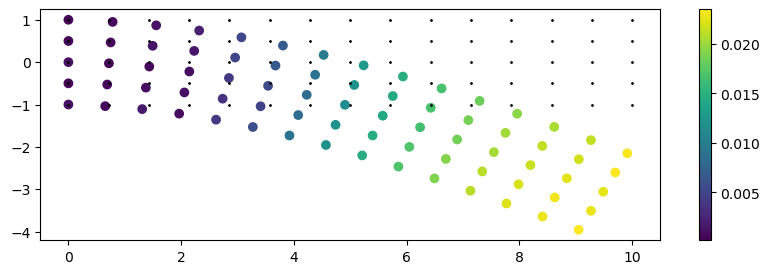

In [30]:
#plot the error on the grid
#size of figure
plt.figure(figsize=(10,3))

# color by error
plt.plot(gt_grid_rest[:,0], gt_grid_rest[:,1], 'o', markersize=1, color='black')
plt.scatter(gt_grid_rest[:,0]+gt_grid[:,0], gt_grid_rest[:,1]+gt_grid[:,1], c=np.linalg.norm(error, axis=1), cmap='viridis')
plt.colorbar()
plt.show()

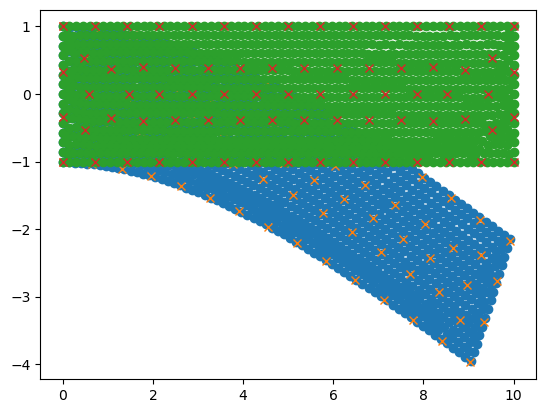

In [9]:
plt.figure()
plt.plot(gt_rest[:,0] + gt_displacement[:,0], gt_rest[:,1] + gt_displacement[:,1], 'o')
plt.plot(pred_rest[:,0] + pred_displacement[:,0], pred_rest[:,1] + pred_displacement[:,1], 'x')

plt.plot(gt_rest[:,0], gt_rest[:,1], 'o')
plt.plot(pred_rest[:,0], pred_rest[:,1], 'x')

plt.show()


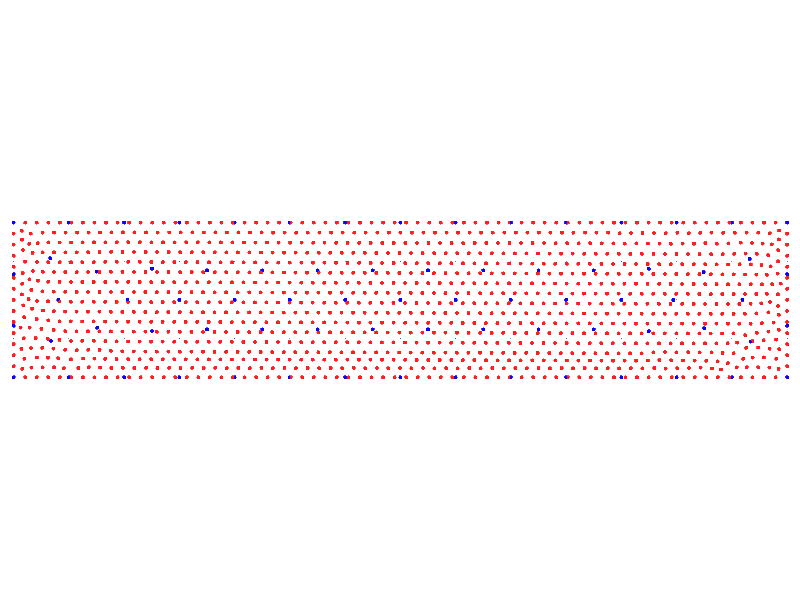

In [10]:
# plot in 3D the same with vedo

gt_points = vedo.Points(gt_rest)
gt_points.color('red')

pred_points = vedo.Points(pred_rest)
pred_points.color('blue')

gt_mesh = vedo.Mesh(gt_grid_rest)
gt_mesh.color('red')

pred_mesh = vedo.Mesh(pred_grid_rest)
pred_mesh.color('blue')

#create plotter object
plot = vedo.Plotter()

#add mesh to plotter
plot.add(gt_points)
plot.add(pred_points)
plot.add(gt_mesh)
plot.add(pred_mesh)

#show plotter interactively
plot.show()

